48/48 [==============================] - 0s 3ms/step
Метрики для каждой целевой переменной:

Next_Tmax:
MAE: 1.189
RMSE: 1.542
R²: 0.748

Next_Tmin:
MAE: 0.902
RMSE: 1.144
R²: 0.787

Время выполнения: 42.69 секунд


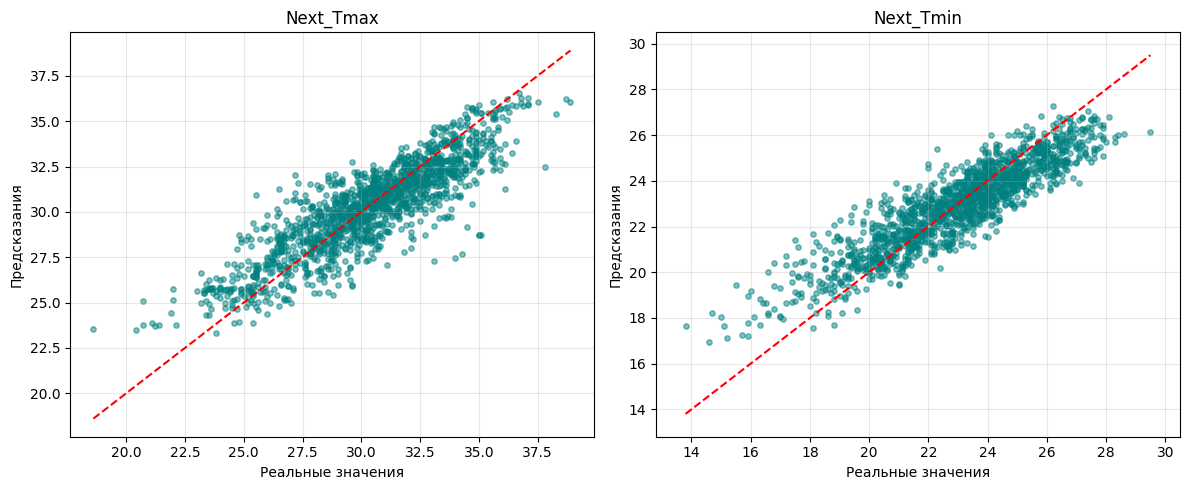

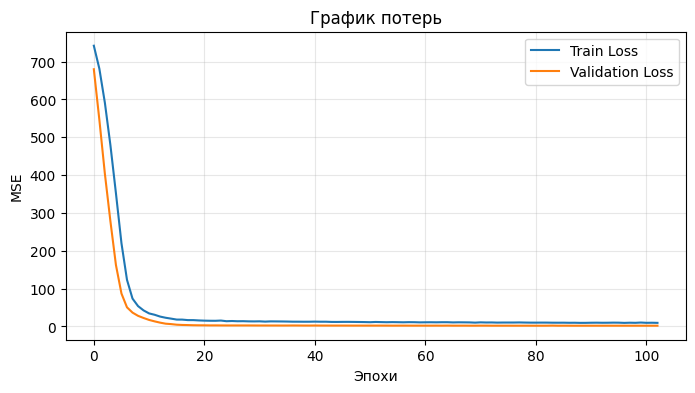

In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Загрузка данных
file_path = 'Bias_correction_ucl.csv'
df = pd.read_csv(file_path, encoding='utf-8')

# Предобработка данных
df_cleaned = df.dropna()
excluded_cols = ['Date', 'station', 'Next_Tmax', 'Next_Tmin']
X = df_cleaned.drop(columns=excluded_cols)
y = df_cleaned[['Next_Tmax', 'Next_Tmin']]

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Создание улучшенной модели MLP
model = Sequential([
    Dense(256, activation='elu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='elu', kernel_initializer='he_normal'),
    Dense(2)
])

optimizer = Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

# Колбэки для оптимизации обучения
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Обучение модели
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=128,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=0
)
end_time = time.time()

# Предсказание
y_pred = model.predict(X_test)

# Вычисление метрик
metrics = {}
for i, target in enumerate(['Next_Tmax', 'Next_Tmin']):
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    
    metrics[target] = {
        'MAE': round(mae, 3),
        'RMSE': round(rmse, 3),
        'R²': round(r2, 3)
    }

# Вывод результатов
print("Метрики для каждой целевой переменной:")
for target, values in metrics.items():
    print(f"\n{target}:")
    print(f"MAE: {values['MAE']}")
    print(f"RMSE: {values['RMSE']}")
    print(f"R²: {values['R²']}")

print(f"\nВремя выполнения: {round(end_time - start_time, 2)} секунд")

# Визуализация
plt.figure(figsize=(12, 5))
targets = ['Next_Tmax', 'Next_Tmin']

for i, target in enumerate(targets):
    plt.subplot(1, 2, i+1)
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.5, s=15, color='teal')
    min_val = min(y_test.iloc[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test.iloc[:, i].max(), y_pred[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5)
    plt.xlabel('Реальные значения', fontsize=10)
    plt.ylabel('Предсказания', fontsize=10)
    plt.title(f'{target}', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(min_val-1, max_val+1)
    plt.ylim(min_val-1, max_val+1)
    
    
    

plt.tight_layout()
plt.show()

# График потерь
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('График потерь')
plt.xlabel('Эпохи')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()